In [20]:
%matplotlib inline

# Create car street table from ways, with unwind order and lengths 🚗 🚗 🚗

This notebook assembles a table of streets from already derived ways, determining street components and paths (unwind order) and street lengths.  

Created on:  2016-11-15  
Last update: 2016-12-07  
Contact: michael.szell@moovel.com, michael.szell@gmail.com (Michael Szell)

In [13]:
cityname = "berlin"

pathdatain = '/Users/szellmi/Documents/lab-mobviz/_playground/berlin-street-wurst/'
pathdataout = '/Users/szellmi/Documents/lab-mobviz/_playground/berlin-street-wurst/'

In [14]:
# preliminaries
from __future__ import unicode_literals
import sys
import csv
import os
import math
import pprint
pp = pprint.PrettyPrinter(indent=4)
import requests
import gzip
from collections import defaultdict
import time
import datetime
import numpy as np
from scipy import stats
import pyprind
import itertools
import logging
from ast import literal_eval as make_tuple
from collections import OrderedDict
from retrying import retry

import osmnx as ox
import networkx as nx
import json
from shapely.geometry import mapping, shape, LineString, LinearRing, Polygon, MultiPolygon
import shapely
import shapely.ops as ops
from functools import partial
import pyproj
from scipy import spatial
from haversine import haversine

import pymongo
from pymongo import MongoClient

# plotting stuff
import matplotlib.pyplot as plt

with open(pathdatain + cityname +"_streetnames.txt", "r") as ins:
    streetnames = []
    for line in ins:
        streetnames.append(line.rstrip('\n'))

In [15]:
client = MongoClient()
db_raw = client[cityname+'_raw']
ways_raw = db_raw['ways']
nodes_raw = db_raw['nodes']
db_derived = client[cityname+'_derived']
streets = db_derived['streets']
ways_derived = db_derived['ways']

In [29]:
def file_len(fname): # http://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def assembleStreet(ways_raw, ways_derived, nodes_raw, streetname = "Achillesstraße", drawit = False, debug = False):
    oxelements = []
    elemnodesint = set()
    elemnodesint_real = set()
    elemways = []
    elemnodes = []
    nodesdict = {}
    for i,way in enumerate(ways_raw.find({"$and": [{"tags.name.name":streetname},{"$or": [{"tags.highway.highway":"residential"},{"tags.highway.highway":"primary"}, {"tags.highway.highway":"secondary"}, {"tags.highway.highway":"tertiary"},{"tags.highway.highway":"unclassified"}]}]})):
        if "public_transport" not in way["tags"]:
            for n in way["nodes"]:
                elemnodesint.add(int(n))

    for n in elemnodesint:
        for nd in nodes_raw.find({"_id": n}):
            elemnodesint_real.add(int(nd["_id"]))
            elemnodes.append({"id": int(nd["_id"]), "lat": nd["loc"]["coordinates"][1], "lon": nd["loc"]["coordinates"][0], "type": "node"})
            nodesdict[str(int(nd["_id"]))] = {"lat": nd["loc"]["coordinates"][1], "lon": nd["loc"]["coordinates"][0]}

    streetlength = 0
    for i,way in enumerate(ways_raw.find({"tags.name.name":streetname})):
        if "public_transport" not in way["tags"]:
            wayinfo = ways_derived.find_one({"_id":int(way["_id"])})
            waylength = wayinfo["properties_derived"]["length"]
            streetlength += waylength
            elemways.append({"id": int(way["_id"]), "nodes":[int(way["nodes"][k]) for k in range(len(way["nodes"])) if int(way["nodes"][k]) in elemnodesint_real], "tags": way["tags"], "type": "way"})

    oxelements = [{"elements": elemnodes + elemways}]
    if debug:
        # Check if nodes are missing
        if len(elemnodesint_real) < len(elemnodesint):
            print(str(len(elemnodesint)-len(elemnodesint_real)) + " nodes are missing.")
        print("oxelements:")
        pp.pprint(oxelements)
        
    G = ox.create_graph(oxelements, retain_all=True)
    if drawit:
        fig, ax = ox.plot_graph(G)
    G = nx.Graph(G)
    G = G.to_undirected()
    ccs = list(nx.connected_component_subgraphs(G))

    components = []
    for c in range(len(ccs)):
        deglist = np.array(list((ccs[c].degree_iter())))
        endptindices = np.where(deglist[:, 1] == 1)
        # Look which of the endpoints lies most western, take that as the source for DFS traversal
        west = float('inf')
        source = deglist[0, 0]
        for i in list(endptindices[0]):
            westthis = nodesdict[str(deglist[i, 0])]["lon"]
            if westthis < west:
                source = deglist[i, 0]
                west = westthis

        component = []
        dfsedges = list(nx.dfs_edges(ccs[c], source))
        nend = dfsedges[0][0]
        path = [str(nend)]
        for e in dfsedges:
            if e[0] == nend: # path grows
                path.append(str(e[1]))
            else: # new path
                component.append(path)
                path = [str(e[0]), str(e[1])]
            nend = e[1]    
        component.append(path) # last path
        components.append(component)
        
    output = {"tags":{"name":streetname, "length": streetlength}, "components":components, "nodes":nodesdict}
    return output

In [ ]:
# Test case. To get its output, insert this in the above function after oxelements = [{"elements": elemnodes + elemways}]
oxelements = [{"elements": [{   'id': 1,
                            'lat': 0,
                            'lon': -1,
                            'type': 'node'},
                            {   'id': 2,
                            'lat': 0,
                            'lon': 1,
                            'type': 'node'},
                            {   'id': 3,
                            'lat': -1,
                            'lon': 1,
                            'type': 'node'},
                            {   'id': 4,
                            'lat': -2,
                            'lon': 1,
                            'type': 'node'},
                            {   'id': 5,
                            'lat': 0,
                            'lon': 2,
                            'type': 'node'},
                            {   'id': 6,
                            'lat': -1,
                            'lon': 0,
                            'type': 'node'},
                            {   'id': 7,
                            'lat': 0,
                            'lon': 3,
                            'type': 'node'},
                            {   'id': 8,
                            'lat': -1,
                            'lon': 4,
                            'type': 'node'},
                            {   'id': 91,
                            'nodes': [1, 2, 3],
                            'type': 'way'},
                            {   'id': 92,
                            'nodes': [2, 5],
                            'type': 'way'},
                            {   'id': 93,
                            'nodes': [3, 4],
                            'type': 'way'},
                            {   'id': 94,
                            'nodes': [6, 3],
                            'type': 'way'},
                            {   'id': 95,
                            'nodes': [7, 8],
                            'type': 'way'}
                           ]}]    
nodesdict = {"1":{'lat': 0, 'lon': -1}, 
            "2":{'lat': 0, 'lon': 1}, 
            "3":{'lat': -1, 'lon': 1}, 
            "4":{'lat': -2, 'lon': 1}, 
            "5":{'lat': 0, 'lon': 2}, 
            "6":{'lat': -1, 'lon': 0}, 
            "7":{'lat': 0, 'lon': 3}, 
            "8":{'lat': -1, 'lon': 4}
            }

#### Next cell: mind the streets.drop()!

In [ ]:
streets.drop()  
bar = pyprind.ProgBar(len(streetnames), bar_char='█', update_interval=1)
streetnames_error = []
for i,streetname in enumerate(streetnames):
    try:
        res = assembleStreet(ways_raw, ways_derived, nodes_raw, streetname)
        res["_id"] = i+1
        streets.update_one({"_id":res["_id"]}, {"$set":res}, upsert=True)
    except:
        #print(streetname + " could not be inserted.")
        streetnames_error.append(streetname)
        #sys.exit()
    bar.update(item_id = streetname)
    
with open(pathdatain + cityname +"_streetnameserror.txt", "w") as f: 
    for s in streetnames_error:
        f.write("%s\n" % s)

0%                          100%
[                              ] | ETA: 02:30:32 | Item ID: Adolf-Menzel-Straße

oxelements:
[   {   'elements': [   {   'id': 3579071184,
                            'lat': 52.5155422,
                            'lon': 13.5066012,
                            'type': 'node'},
                        {   'id': 2925621786,
                            'lat': 52.5153057,
                            'lon': 13.5065374,
                            'type': 'node'},
                        {   'id': 2925621787,
                            'lat': 52.5158488,
                            'lon': 13.506684,
                            'type': 'node'},
                        {   'id': 2925621788,
                            'lat': 52.5163932,
                            'lon': 13.5068309,
                            'type': 'node'},
                        {   'id': 3577188615,
                            'lat': 52.5161189,
                            'lon': 13.5067492,
                            'type': 'node'},
                        {   'id': 289012298,
                   

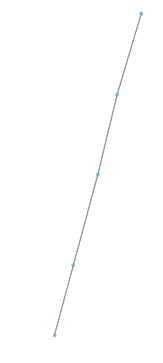

In [30]:
bla = assembleStreet(ways_raw, ways_derived, nodes_raw, "Alzeyweg", True, True)